# Exercise 3
## Problem 0)

*** Conjugate Gradient converged ***
Converged in 170 iterations


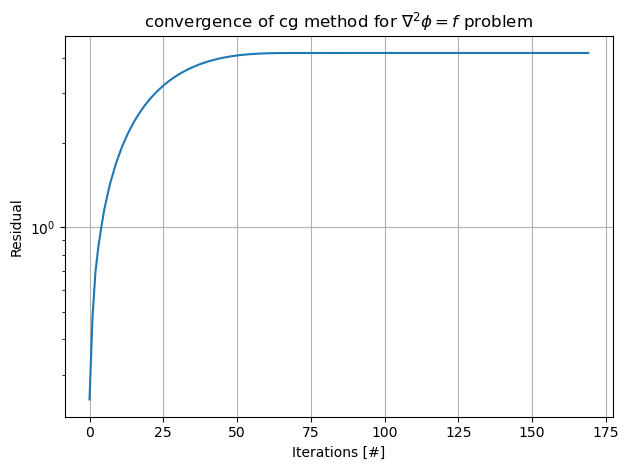

In [6]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def Amult(U, m):
    """
    matrix-free multiplication with the 5-point Laplacian operator, the init problem for the
    U: the vector to be multiplied
    m: the number of grid points in one dimension
    """
    h = 1 / (m + 1)
    AhU = np.zeros_like(U)

    # making u to 2d
    U_grid = U.reshape((m, m))

    # apply the 5-point laplacian
    for i in range(m):
        for j in range(m):
            # here we define the 5 point laplacian in our U in a grid like this:
            ##o##
            #ooo#
            ##o##
            # where o is the point we are calculating the laplacian
            # and # are the points we are using to calculate the laplacian
            if i > 0:
                AhU[i * m + j] += U_grid[i-1, j]
            if i < m-1:
                AhU[i * m + j] += U_grid[i+1, j]
            if j > 0:
                AhU[i * m + j] += U_grid[i, j-1]
            if j < m-1:
                AhU[i * m + j] += U_grid[i, j+1]

            AhU[i * m + j] -= 4 * U_grid[i, j]
    
    return AhU / h**2  # scaling by h^2 for the finite difference discretization


def poisson_solver_cg_amult(N = 20, tol = 1e-8, max_iter = 10000):
    
    # we define the grid spacing
    h = 1 / (N + 1)

     # we define the init guess
    u0 = np.zeros(N**2)

    # we define the right hand side of the set of eqquations of length N**2
    f = +np.ones(N**2)  # Note the minus sign here

    residuals = []  # for storing the residuals

    def callback(rk):
        residuals.append(np.linalg.norm(rk))

    # Wrap Amult in a LinearOperator, matvec means that it should take x as a lambda function
    A_operator = spla.LinearOperator((N**2, N**2), matvec = lambda x: Amult(x, N))

    # solve the linear system using the conjugate gradient (cg) method
    # a_operator: the matrix A in the equation Ax = b
    # f: the right-hand side of the equation
    # x0: the initial guess
    # rtol: the relative tolerance for convergence
    # max_iter: the maximum number of iterations in the solver
    # callback: a function that is called after each iteration of the solver, build in
    # so it takes it as a inpuitx
    u, info = spla.cg(A_operator, f, x0=u0, rtol=tol, maxiter=max_iter, callback=callback)

    # info will return 0 if the computation has converged
    if info == 0:
        print("*** Conjugate Gradient converged ***")
        print(f"Converged in {len(residuals)} iterations")
    else:
        print(f"*** Warning: CG did not fully converge (info={info})")

    return u.reshape((N, N)), residuals, h # we reshape back to n by n grid

# testing the function
N = 100
tol = 1e-7

u, residuals, h = poisson_solver_cg_amult(N, tol)
# we print the number of iterations at which the solution converged

plt.figure()
plt.semilogy(residuals)
plt.xlabel("Iterations [#]")
plt.ylabel("Residual")
plt.title(r"convergence of cg method for $\nabla^2 \phi=f$ problem")
plt.grid()
plt.tight_layout()
plt.savefig("convergence_cg.png", dpi=300)
plt.show()


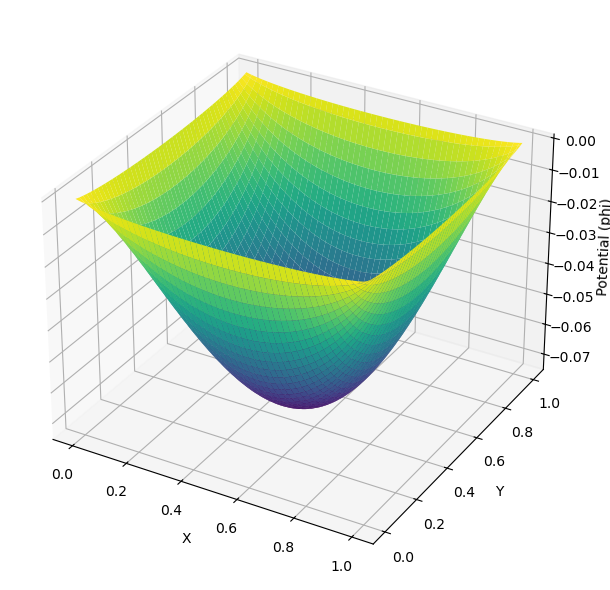

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'u' is the solution vector returned by poisson_solver_cg_amult
N = 100  # Adjust N to match the grid size used in your solver
u_2d = u.reshape((N, N))  # Reshape u back to a 2D array

# Create meshgrid for the x and y coordinates of the 2D grid
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, u_2d, cmap='viridis', edgecolor='none')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential (phi)')
plt.tight_layout()
plt.savefig("3d_surface_plot.png", dpi=300)

# Show the plot
plt.show()


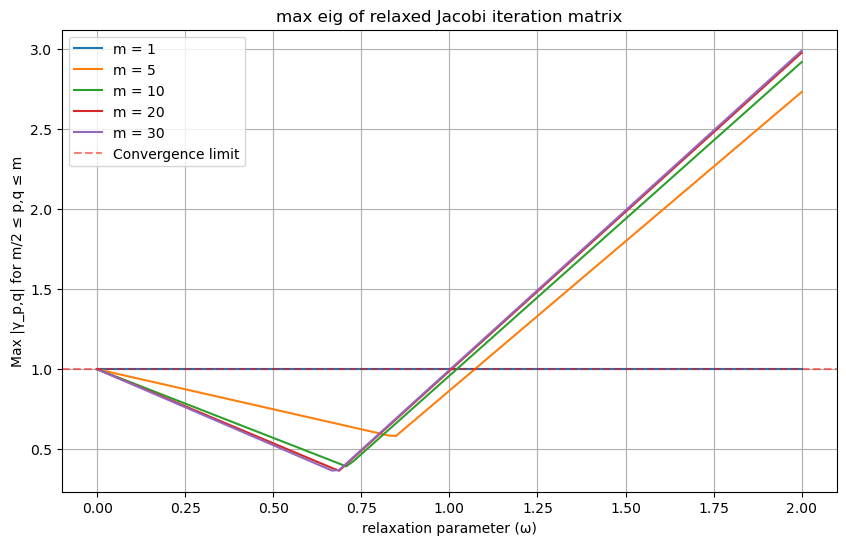

Suggested optimal relaxation parameter (omega): 0.6666666666666666


In [8]:
def compute_eigenvalues(omega, m):
    """
    Compute eigenvalues of the relaxed Jacobi iteration matrix for the 5-point Laplacian.
    
    Parameters:
    - omega: relaxation parameter
    - m: grid size
    
    Returns:
    - max_eigenvalue: maximum eigenvalue magnitude for high frequencies (m/2 <= p,q <= m)
    """
    max_eig = 0  # Initialize the maximum eigenvalue magnitude
    for p in range(m // 2, m + 1):  # Loop over high-frequency modes in the x-direction
        for q in range(m // 2, m + 1):  # Loop over high-frequency modes in the y-direction
            # Compute eigenvalues of the 5-point Laplacian for mode (p, q)
            lambda_pq = 2 * (np.cos(p * np.pi / (m + 1)) + np.cos(q * np.pi / (m + 1)))
            # Compute eigenvalues of the relaxed Jacobi iteration matrix
            gamma_pq = 1 - omega + omega * lambda_pq / 4
            
            # Update the maximum eigenvalue magnitude
            max_eig = max(max_eig, abs(gamma_pq))
    
    return max_eig  # Return the maximum eigenvalue magnitude

# Analyze different values of omega to find the optimal one
m_values = [1, 5, 10, 20, 30]  # Different grid sizes to analyze
omega_values = np.linspace(0, 2, 100)  # Range of relaxation parameters to test

plt.figure(figsize=(10, 6))  # Create a new figure for the plot
for m in m_values:  # Loop over different grid sizes
    max_eigenvalues = []  # Store maximum eigenvalues for each omega
    for omega in omega_values:  # Loop over relaxation parameters
        max_eig = compute_eigenvalues(omega, m)  # Compute the maximum eigenvalue
        max_eigenvalues.append(max_eig)  # Append to the list
    
    # Plot the maximum eigenvalue magnitude as a function of omega
    plt.plot(omega_values, max_eigenvalues, label=f'm = {m}')

# Add a horizontal line at y=1 to indicate the convergence limit
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Convergence limit')
plt.ylabel('Max |γ_p,q| for m/2 ≤ p,q ≤ m')  # Label for the y-axis
plt.xlabel('relaxation parameter (ω)')  # Label for the x-axis
plt.title('max eig of relaxed Jacobi iteration matrix')  # Plot title
plt.grid(True)  # Add a grid to the plot
plt.legend()  # Add a legend to the plot
plt.show()  # Display the plot

# Suggested optimal omega based on observation
optimal_omega = 2 / 3  # Optimal relaxation parameter for convergence
print(f"Suggested optimal relaxation parameter (omega): {optimal_omega}")


# now we use the smooth function to solve the poisson equation


In [9]:
def smooth(U, omega, m, F):
    """
    Matrix-free relaxed Jacobi iteration for the 5-point Laplacian discretization in 2D.
    
    Parameters:
    - U: current iterate (m by m grid flattened to length m**2)
    - omega: relaxation parameter
    - m: grid size
    - F: right-hand side vector of length m**2
    
    Returns:
    - Unew: new iterate after one relaxed Jacobi step
    """
    h = 1 / (m + 1)  # Grid spacing
    h2 = h * h  # Square of the grid spacing
    
    # Reshape U to a 2D grid for easier access
    U_grid = U.reshape((m, m))
    Unew = np.zeros_like(U)  # Initialize the new iterate
    Unew_grid = Unew.reshape((m, m))  # Reshape to 2D for easier access
    
    # Apply one relaxed Jacobi iteration
    for i in range(m):  # Loop over grid rows
        for j in range(m):  # Loop over grid columns
            # Compute the sum of neighboring points
            neighbors_sum = 0
            if i > 0:  # Add the top neighbor if it exists
                neighbors_sum += U_grid[i-1, j]
            if i < m-1:  # Add the bottom neighbor if it exists
                neighbors_sum += U_grid[i+1, j]
            if j > 0:  # Add the left neighbor if it exists
                neighbors_sum += U_grid[i, j-1]
            if j < m-1:  # Add the right neighbor if it exists
                neighbors_sum += U_grid[i, j+1]
            
            # Apply relaxed Jacobi formula: U_new = (1-omega)*U + omega/4 * (neighbors_sum + h²*F)
            Unew_grid[i, j] = (1 - omega) * U_grid[i, j] + (omega / 4) * (neighbors_sum + h2 * F[i * m + j])
    
    return Unew  # Return the new iterate

In [13]:
U = np.ones((5**2))
Amult(U, 5).reshape(5, 5)

array([[-72., -36., -36., -36., -72.],
       [-36.,   0.,   0.,   0., -36.],
       [-36.,   0.,   0.,   0., -36.],
       [-36.,   0.,   0.,   0., -36.],
       [-72., -36., -36., -36., -72.]])